In [1]:
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence

# Example Data

In [23]:
sentences = [
	'I love my dog',
	'I love my cat',
	'It is quite sunny outside',
]

tokenizer = text.Tokenizer(
	num_words = 100,			# vocab size
	oov_token = "<OOV>",		# word out of vocab to replace with
)
tokenizer.fit_on_texts(sentences)

tokenizer.word_index
tokenizer.word_counts

sequences = tokenizer.texts_to_sequences(sentences)

sequence.pad_sequences(
	sequences,				# 2D array of sequences (tokened sentences)
	padding = "post",		# fill with zeros from
	maxlen = 3,				# lenght of sentence
	truncating = "pre",		# remove extra words from
)

array([[ 3,  4,  5],
       [ 3,  4,  6],
       [ 9, 10, 11]])

# Sarcasm

In [4]:
# dataset url: https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection

import json

sentences = []
labels = []
# Load the JSON file
with open("datasets/Sarcasm_Headlines_Dataset.json", 'r') as f:
	for i in f.readlines():
		data = json.loads(i)
		sentences.append(data['headline'])
		labels.append(data['is_sarcastic'])

In [5]:
# Number of examples to use for training
training_size = 20000

# Vocabulary size of the tokenizer
vocab_size = 10000

# Maximum length of the padded sequences
max_length = 32

# Output dimensions of the Embedding layer
embedding_dim = 16

In [6]:
# Split the sentences
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

# Split the labels
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [7]:
# Parameters for padding and OOV tokens
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = text.Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = sequence.pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = sequence.pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [18]:
embedding_dim

16

In [16]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 32, 16)            160000    
                                                                 
 global_average_pooling1d_2   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 24)                408       
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Compile the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [10]:
num_epochs = 30

# Train the model
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 4s - loss: 0.5908 - accuracy: 0.6786 - val_loss: 0.4189 - val_accuracy: 0.8277 - 4s/epoch - 6ms/step
Epoch 2/30
625/625 - 2s - loss: 0.3263 - accuracy: 0.8702 - val_loss: 0.3460 - val_accuracy: 0.8571 - 2s/epoch - 3ms/step
Epoch 3/30
625/625 - 1s - loss: 0.2429 - accuracy: 0.9047 - val_loss: 0.3423 - val_accuracy: 0.8532 - 1s/epoch - 2ms/step
Epoch 4/30
625/625 - 1s - loss: 0.1964 - accuracy: 0.9248 - val_loss: 0.3537 - val_accuracy: 0.8551 - 1s/epoch - 2ms/step
Epoch 5/30
625/625 - 1s - loss: 0.1631 - accuracy: 0.9391 - val_loss: 0.3777 - val_accuracy: 0.8529 - 1s/epoch - 2ms/step
Epoch 6/30
625/625 - 1s - loss: 0.1385 - accuracy: 0.9501 - val_loss: 0.4134 - val_accuracy: 0.8450 - 1s/epoch - 2ms/step
Epoch 7/30
625/625 - 1s - loss: 0.1187 - accuracy: 0.9578 - val_loss: 0.4557 - val_accuracy: 0.8413 - 1s/epoch - 2ms/step
Epoch 8/30
625/625 - 2s - loss: 0.1030 - accuracy: 0.9660 - val_loss: 0.4863 - val_accuracy: 0.8414 - 2s/epoch - 3ms/step
Epoch 9/30
625/625 - 2s 

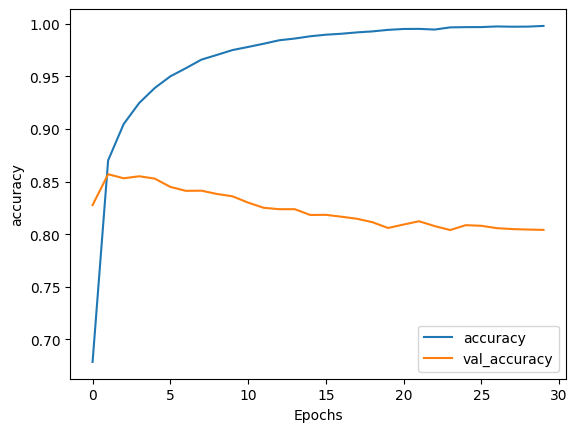

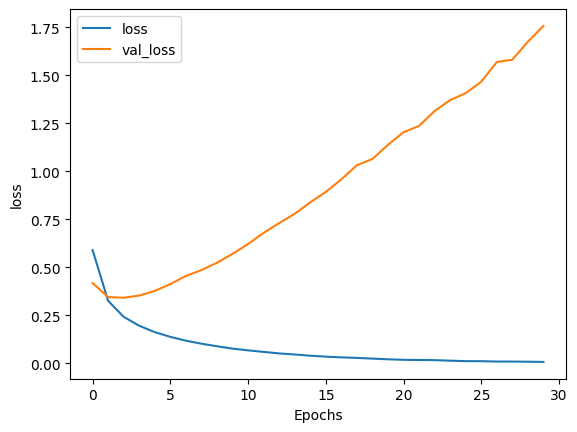

In [11]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [12]:
# Get the index-word dictionary
reverse_word_index = tokenizer.index_word

# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape) 


(10000, 16)


In [13]:
import io

# Open writeable files
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, vocab_size):

  # Get the word associated at the current index
  word_name = reverse_word_index[word_num]

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(word_name + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()

# IMDB

In [44]:
import tensorflow_datasets as tfds

In [46]:
imdb, info = tfds.load(
	"imdb_reviews",
	with_info = True,
	as_supervised = True,
)

In [65]:
train_data, test_data = imdb['train'], imdb['test']

# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Loop over all training examples and save the sentences and labels
for s,l in tqdm(train_data):
  training_sentences.append(s.numpy().decode('utf8'))
  training_labels.append(l.numpy())

# Loop over all test examples and save the sentences and labels
for s,l in tqdm(test_data):
  testing_sentences.append(s.numpy().decode('utf8'))
  testing_labels.append(l.numpy())

# Convert labels lists to numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

100%|██████████| 25000/25000 [00:04<00:00, 5705.07it/s]


In [68]:
# Parameters
vocab_size = 10000
max_length = 120
embedding_dim = 16
trunc_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = text.Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = sequence.pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = sequence.pad_sequences(testing_sequences,maxlen=max_length, truncating=trunc_type)


In [84]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Setup the training parameters
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 6)                 11526     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [85]:
num_epochs = 10

# Train the model
model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 5s 4ms/step - loss: 0.4898 - accuracy: 0.7484 - val_loss: 0.3786 - val_accuracy: 0.8305
Epoch 2/10
782/782 [==============================] - 3s 4ms/step - loss: 0.2428 - accuracy: 0.9040 - val_loss: 0.4034 - val_accuracy: 0.8218
Epoch 3/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0983 - accuracy: 0.9735 - val_loss: 0.5104 - val_accuracy: 0.8049
Epoch 4/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0250 - accuracy: 0.9967 - val_loss: 0.6106 - val_accuracy: 0.8040
Epoch 5/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0068 - accuracy: 0.9994 - val_loss: 0.6850 - val_accuracy: 0.8045
Epoch 6/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0022 - accuracy: 0.9999 - val_loss: 0.7775 - val_accuracy: 0.8005
Epoch 7/10
782/782 [==============================] - 4s 5ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.8075 - val_accuracy: 0.8066
Epoch 

In [86]:
model.evaluate(testing_padded, testing_labels_final)

782/782 [==============================] - 1s 1ms/step - loss: 0.9455 - accuracy: 0.8070


[0.9455122947692871, 0.8070399761199951]

In [92]:
# Get the weights of the embedding layer
embedding_weights = model.layers[0].get_weights()[0]
embedding_weights.shape

(10000, 16)

In [93]:
import io

# Get the index-word dictionary
reverse_word_index = tokenizer.index_word

# Open writeable files
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, vocab_size):

  # Get the word associated at the current index
  word_name = reverse_word_index[word_num]

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(word_name + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()